In [1]:
import os
import IPython
os.environ['NUMBA_CACHE_DIR'] = IPython.paths.get_ipython_cache_dir()
import librosa

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os

import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 



In [4]:
import librosa

In [5]:
import pyaudio # Sürüm 0.2.11
import wave # Sürüm 0.0.2

audio = pyaudio.PyAudio() # pyaudio nesnesi oluşturma

stream = audio.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024) # Bir ses akışı açma

frames = []

try:
   while True:
         data = stream.read(1024) # Ses okuma
         frames.append(data) # Ses verisini ekleme

except KeyboardInterrupt: # Ctrl-C ile çıkış
       pass		 

stream.stop_stream() # Ses okumayı durdurma
stream.close() # Akışı kapatma
audio.terminate() # pyaudio nesnesini sona erdirme

wave_file = wave.open("kayit.wav", "wb") # Ses dosyası oluşturma
wave_file.setnchannels(1)
wave_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16)) 
wave_file.setframerate(44100)
wave_file.writeframes(b''.join(frames)) # Ses verilerini yazma
wave_file.close() # Ses dosyasını kapatma

In [62]:
#Librosa kullanarak ses sinyalini oku
audio_file_path='PoliceSiren.wav'

#sesi dijital hale getir.
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path) 

In [63]:
#Librosa herhangi bir stereo sinyalini monoya dönüştürür.
# Yani librosa dönüştürülmüş sinyal verisi tek boyutludur 
#çünkü tüm sinyalleri monoya çevirir ve bu mono sinyal formu üzerinden ses dosyanızın sinyal özelliklerini alır.

print(librosa_audio_data)

[-6.1840816e-05  1.1284169e-04 -1.3084468e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


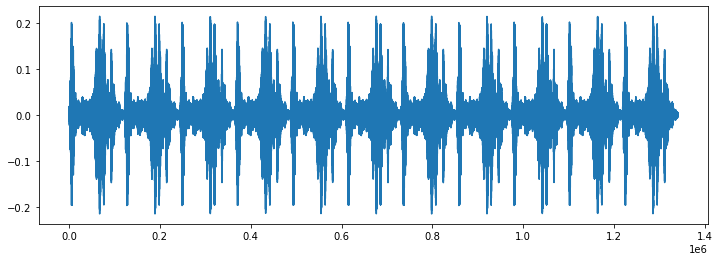

In [64]:
# Librosa ses verilerini çizelim
# 1 kanallı orijinal ses

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [65]:
# Scipy ile okuyalım

from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [66]:
wave_audio

array([[-1,  3],
       [ 0,  0],
       [ 0,  3],
       ...,
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]], dtype=int16)

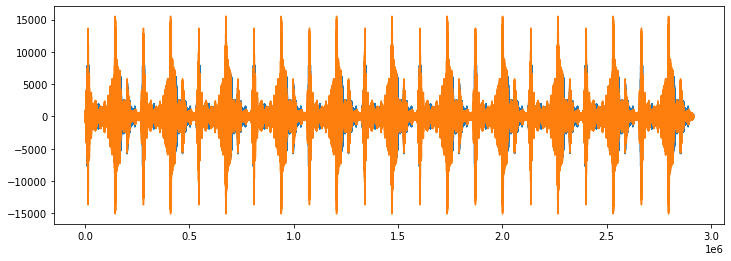

In [67]:
# 2 kanallı orijinal ses

plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

In [12]:
#n_mfcc: döndürülecek MFCC sayısı
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)   
print(mfccs.shape)

(40, 149)


In [13]:
mfccs

array([[-841.2898   , -841.2898   , -841.2898   , ..., -446.33136  ,
        -454.10904  , -483.372    ],
       [   0.       ,    0.       ,    0.       , ...,   79.857956 ,
          74.93303  ,   73.258316 ],
       [   0.       ,    0.       ,    0.       , ...,  -38.61895  ,
         -40.100895 ,  -39.08838  ],
       ...,
       [   0.       ,    0.       ,    0.       , ...,    2.7161412,
           3.2340724,    7.0723333],
       [   0.       ,    0.       ,    0.       , ...,    3.7981935,
           2.4832113,    4.927988 ],
       [   0.       ,    0.       ,    0.       , ...,    6.122978 ,
           6.5655556,    6.380252 ]], dtype=float32)

In [14]:
# Veri kümesindeki her ses dosyası için MFCC'leri çıkaracağız..

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [16]:

# Şimdi her bir ses dosyasını tekrarlıyoruz ve özellikleri ayıklıyoruz
# Mel-Frekans Cepstral Katsayılarını kullanarak

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [04:37, 11.09it/s]C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [10:11, 18.28it/s]C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [10:37, 13.69it/s]


In [17]:
# Extracted_features'ı Pandas veri çerçevesine dönüştüreceğiz

extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [18]:

# Daha sonra veri setini bağımsız ve bağımlı veri setine ayırdık

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [19]:
X.shape

(8732, 40)

In [20]:
X

array([[-2.1735526e+02,  7.0223381e+01, -1.3038527e+02, ...,
        -1.6930530e+00, -6.1698383e-01,  3.8600540e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489316e-01, -5.4468727e-01,  4.4632071e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520660e+01, ...,
         2.0768483e+00,  1.6962967e+00, -9.6140945e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941563e+01, ...,
        -3.0292380e+00,  2.7170293e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903439e+01, ...,
        -7.9082441e+00, -1.6414586e+00,  5.6668439e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386454e-01, -1.1449189e+01, -6.0105853e+00]], dtype=float32)

In [21]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [22]:
y.shape

(8732,)

In [23]:

# Modelimizde (1'ler ve 0'lar) çıktı sınıfları için bir sıcak kodlanmış değere ihtiyacımız olduğundan, 
#Etiket Kodlaması(Label Encoder) yapmalıyız.

# Please remember one-hot encoding:
# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [24]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [26]:
# Veri setini train ve test olarak ayırdık. %20 test verisi olacak
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [27]:

X_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665260e+00, -1.36902380e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305080e+00, -5.27745295e+00, -1.55697155e+00],
       [-4.98715439e+01,  2.65352815e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920465e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939763e+00, ...,
         7.42641270e-01,  7.33490884e-01,  7.11009145e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155220e+01, ...,
         1.46811950e+00, -2.00917006e+00, -8.82181704e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066067e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651139e+00]], dtype=float32)

In [28]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
X_train.shape

(6985, 40)

In [30]:
X_test.shape

(1747, 40)

In [31]:
y_train.shape

(6985, 10)

In [32]:
y_test.shape

(1747, 10)

In [33]:
# Kaç sınıfımız varsa kendi modelimizde kullanmalıyız.
num_labels = 10

In [34]:
#
#CNN modelimizi oluşturuyoruz.
model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5125      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [36]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [37]:
#modelimizi eğitelim
epochscount = 500
num_batch_size = 32 #aynı anda 32 adet veri işlenecek

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/500
219/219 [==============================] - 3s 6ms/step - loss: 8.4902 - accuracy: 0.1374 - val_loss: 2.2485 - val_accuracy: 0.1574
Epoch 2/500
219/219 [==============================] - 1s 4ms/step - loss: 2.4248 - accuracy: 0.1390 - val_loss: 2.1780 - val_accuracy: 0.2152
Epoch 3/500
219/219 [==============================] - 1s 4ms/step - loss: 2.2242 - accuracy: 0.1695 - val_loss: 2.0139 - val_accuracy: 0.2788
Epoch 4/500
219/219 [==============================] - 1s 4ms/step - loss: 2.1553 - accuracy: 0.2102 - val_loss: 1.9862 - val_accuracy: 0.2748
Epoch 5/500
219/219 [==============================] - 1s 4ms/step - loss: 2.0961 - accuracy: 0.2176 - val_loss: 1.9362 - val_accuracy: 0.2873
Epoch 6/500
219/219 [==============================] - 1s 4ms/step - loss: 2.0445 - accuracy: 0.2301 - val_loss: 1.9180 - val_accuracy: 0.2759
Epoch 7/500
219/219 [==============================] - 1s 4ms/step - loss: 2.0079 - accuracy: 0.2534 - val_loss: 1.8660 - val_accuracy: 0.3246

Epoch 58/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9577 - accuracy: 0.6750 - val_loss: 0.7923 - val_accuracy: 0.7441
Epoch 59/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9831 - accuracy: 0.6671 - val_loss: 0.7741 - val_accuracy: 0.7436
Epoch 60/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9633 - accuracy: 0.6749 - val_loss: 0.7661 - val_accuracy: 0.7533
Epoch 61/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9508 - accuracy: 0.6766 - val_loss: 0.7702 - val_accuracy: 0.7556
Epoch 62/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9474 - accuracy: 0.6803 - val_loss: 0.7596 - val_accuracy: 0.7590
Epoch 63/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9472 - accuracy: 0.6809 - val_loss: 0.7741 - val_accuracy: 0.7539
Epoch 64/500
219/219 [==============================] - 1s 4ms/step - loss: 0.9521 - accuracy: 0.6749 - val_loss: 0.7488 - val_accuracy:

Epoch 115/500
219/219 [==============================] - 1s 4ms/step - loss: 0.8441 - accuracy: 0.7174 - val_loss: 0.6564 - val_accuracy: 0.7853
Epoch 116/500
219/219 [==============================] - 1s 4ms/step - loss: 0.8440 - accuracy: 0.7208 - val_loss: 0.6596 - val_accuracy: 0.7928
Epoch 117/500
219/219 [==============================] - 1s 5ms/step - loss: 0.8449 - accuracy: 0.7161 - val_loss: 0.6508 - val_accuracy: 0.7951
Epoch 118/500
219/219 [==============================] - 1s 5ms/step - loss: 0.8328 - accuracy: 0.7217 - val_loss: 0.6444 - val_accuracy: 0.7997
Epoch 119/500
219/219 [==============================] - 1s 5ms/step - loss: 0.8470 - accuracy: 0.7138 - val_loss: 0.6550 - val_accuracy: 0.7922
Epoch 120/500
219/219 [==============================] - 1s 5ms/step - loss: 0.8218 - accuracy: 0.7215 - val_loss: 0.6427 - val_accuracy: 0.7968
Epoch 121/500
219/219 [==============================] - 1s 5ms/step - loss: 0.8525 - accuracy: 0.7167 - val_loss: 0.6525 - val_ac

219/219 [==============================] - 1s 4ms/step - loss: 0.7826 - accuracy: 0.7435 - val_loss: 0.6197 - val_accuracy: 0.8014
Epoch 172/500
219/219 [==============================] - 1s 4ms/step - loss: 0.8097 - accuracy: 0.7290 - val_loss: 0.6029 - val_accuracy: 0.8060
Epoch 173/500
219/219 [==============================] - 1s 4ms/step - loss: 0.8009 - accuracy: 0.7359 - val_loss: 0.6185 - val_accuracy: 0.8008
Epoch 174/500
219/219 [==============================] - 1s 4ms/step - loss: 0.8120 - accuracy: 0.7276 - val_loss: 0.6025 - val_accuracy: 0.8145
Epoch 175/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7616 - accuracy: 0.7426 - val_loss: 0.6162 - val_accuracy: 0.8037
Epoch 176/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7793 - accuracy: 0.7404 - val_loss: 0.6161 - val_accuracy: 0.8100
Epoch 177/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7872 - accuracy: 0.7344 - val_loss: 0.6155 - val_accuracy: 0.8105

219/219 [==============================] - 1s 4ms/step - loss: 0.7496 - accuracy: 0.7508 - val_loss: 0.6181 - val_accuracy: 0.8111
Epoch 228/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7682 - accuracy: 0.7433 - val_loss: 0.6030 - val_accuracy: 0.8077
Epoch 229/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7308 - accuracy: 0.7518 - val_loss: 0.5945 - val_accuracy: 0.8140
Epoch 230/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7681 - accuracy: 0.7413 - val_loss: 0.5920 - val_accuracy: 0.8145
Epoch 231/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7380 - accuracy: 0.7497 - val_loss: 0.5987 - val_accuracy: 0.8283
Epoch 232/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7635 - accuracy: 0.7555 - val_loss: 0.5928 - val_accuracy: 0.8208
Epoch 233/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7527 - accuracy: 0.7489 - val_loss: 0.5973 - val_accuracy: 0.8208

219/219 [==============================] - 1s 4ms/step - loss: 0.7210 - accuracy: 0.7613 - val_loss: 0.5808 - val_accuracy: 0.8145
Epoch 284/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7336 - accuracy: 0.7553 - val_loss: 0.5667 - val_accuracy: 0.8260
Epoch 285/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7416 - accuracy: 0.7489 - val_loss: 0.5663 - val_accuracy: 0.8180
Epoch 286/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7258 - accuracy: 0.7631 - val_loss: 0.5803 - val_accuracy: 0.8220
Epoch 287/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7470 - accuracy: 0.7518 - val_loss: 0.5691 - val_accuracy: 0.8185
Epoch 288/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7246 - accuracy: 0.7601 - val_loss: 0.5433 - val_accuracy: 0.8271
Epoch 289/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7215 - accuracy: 0.7598 - val_loss: 0.5841 - val_accuracy: 0.8180

219/219 [==============================] - 1s 5ms/step - loss: 0.7145 - accuracy: 0.7606 - val_loss: 0.5518 - val_accuracy: 0.8226
Epoch 340/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7163 - accuracy: 0.7636 - val_loss: 0.5573 - val_accuracy: 0.8323
Epoch 341/500
219/219 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.7761 - val_loss: 0.5372 - val_accuracy: 0.8351
Epoch 342/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7113 - accuracy: 0.7695 - val_loss: 0.5673 - val_accuracy: 0.8329
Epoch 343/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7023 - accuracy: 0.7709 - val_loss: 0.5671 - val_accuracy: 0.8197
Epoch 344/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7116 - accuracy: 0.7642 - val_loss: 0.5794 - val_accuracy: 0.8283
Epoch 345/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7195 - accuracy: 0.7601 - val_loss: 0.5810 - val_accuracy: 0.8174

219/219 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.7728 - val_loss: 0.5707 - val_accuracy: 0.8214
Epoch 396/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7023 - accuracy: 0.7727 - val_loss: 0.5605 - val_accuracy: 0.8329
Epoch 397/500
219/219 [==============================] - 1s 5ms/step - loss: 0.7132 - accuracy: 0.7661 - val_loss: 0.5638 - val_accuracy: 0.8122
Epoch 398/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7061 - accuracy: 0.7686 - val_loss: 0.5655 - val_accuracy: 0.8185
Epoch 399/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7014 - accuracy: 0.7722 - val_loss: 0.5558 - val_accuracy: 0.8271
Epoch 400/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7003 - accuracy: 0.7755 - val_loss: 0.5368 - val_accuracy: 0.8392
Epoch 401/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7010 - accuracy: 0.7725 - val_loss: 0.5523 - val_accuracy: 0.8317

219/219 [==============================] - 1s 4ms/step - loss: 0.6953 - accuracy: 0.7711 - val_loss: 0.5523 - val_accuracy: 0.8386
Epoch 452/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7008 - accuracy: 0.7699 - val_loss: 0.5375 - val_accuracy: 0.8386
Epoch 453/500
219/219 [==============================] - 1s 4ms/step - loss: 0.6841 - accuracy: 0.7744 - val_loss: 0.5521 - val_accuracy: 0.8351
Epoch 454/500
219/219 [==============================] - 1s 4ms/step - loss: 0.6968 - accuracy: 0.7689 - val_loss: 0.5562 - val_accuracy: 0.8311
Epoch 455/500
219/219 [==============================] - 1s 4ms/step - loss: 0.6956 - accuracy: 0.7739 - val_loss: 0.5393 - val_accuracy: 0.8392
Epoch 456/500
219/219 [==============================] - 1s 4ms/step - loss: 0.7058 - accuracy: 0.7699 - val_loss: 0.5507 - val_accuracy: 0.8329
Epoch 457/500
219/219 [==============================] - 1s 4ms/step - loss: 0.6775 - accuracy: 0.7821 - val_loss: 0.5560 - val_accuracy: 0.8369

In [38]:
#modelin başarımı
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8277046084403992


In [39]:
X_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.33935   ,
        -14.88148   ,  -19.12843   ,   -0.581684  ,  -16.130577  ,
        -21.339075  ,    7.673635  ,  -29.16449   ,  -18.950253  ,
         -2.9579995 ,   -8.162331  ,  -15.153101  ,   -6.6048055 ,
         -7.5685973 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340123 ,  -19.228804  ,   -4.630231  ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346074,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.583201  ,
         -1.2624055 ,   17.700016  ,   13.847462  ,   -5.1862826 ],
      dtype=float32)

In [40]:
#model.predict_classes(X_test)
np.argmax(X_test, axis=1)

array([1, 3, 3, ..., 1, 1, 1], dtype=int64)

In [77]:
#Dosyayı ver
filename="PoliceSiren.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [78]:
print(mfccs_scaled_features)

[-5.0995752e+02  5.8146946e+01 -2.6707426e+01 -1.7372311e+01
 -2.8753526e+00  1.1949612e+01  3.4049835e+01  2.4762629e+01
  4.6244879e+00  3.2125171e-03  4.9547729e+00  1.8490025e+00
 -1.0731525e+01 -1.1760646e+01 -9.5060568e+00 -1.4619814e+01
 -1.1907404e+01 -7.1366186e+00 -6.3352227e+00 -2.0210265e-01
  1.8496817e+00 -4.4661732e+00 -6.6702261e+00 -4.1697803e+00
 -8.3460432e-01  1.0379701e+00 -1.6958172e+00 -3.1239166e+00
  6.9476908e-01  4.1810641e+00  6.1519116e-01 -7.5993414e+00
 -7.3442678e+00 -1.6432673e+00 -1.6267996e+00 -1.0078022e+00
 -7.9470462e-01 -3.7893722e+00 -2.6085303e+00 -2.7019656e+00]


In [79]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [80]:
mfccs_scaled_features.shape

(1, 40)

In [81]:
print(mfccs_scaled_features)

[[-5.0995752e+02  5.8146946e+01 -2.6707426e+01 -1.7372311e+01
  -2.8753526e+00  1.1949612e+01  3.4049835e+01  2.4762629e+01
   4.6244879e+00  3.2125171e-03  4.9547729e+00  1.8490025e+00
  -1.0731525e+01 -1.1760646e+01 -9.5060568e+00 -1.4619814e+01
  -1.1907404e+01 -7.1366186e+00 -6.3352227e+00 -2.0210265e-01
   1.8496817e+00 -4.4661732e+00 -6.6702261e+00 -4.1697803e+00
  -8.3460432e-01  1.0379701e+00 -1.6958172e+00 -3.1239166e+00
   6.9476908e-01  4.1810641e+00  6.1519116e-01 -7.5993414e+00
  -7.3442678e+00 -1.6432673e+00 -1.6267996e+00 -1.0078022e+00
  -7.9470462e-01 -3.7893722e+00 -2.6085303e+00 -2.7019656e+00]]


In [82]:
print(mfccs_scaled_features.shape)

(1, 40)


In [83]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 52ms/step


In [84]:
result_array

array([[2.6418044e-29, 1.2532621e-14, 2.6674955e-14, 5.4344389e-07,
        8.3328226e-19, 9.0126158e-18, 2.2510313e-13, 7.3624592e-31,
        9.9999940e-01, 6.7653606e-14]], dtype=float32)

In [85]:
result_classes = ["hava-durumu-olayı","araba-korna-sesi","oynayan-çocuk-sesi","köpek-sesi","sondaj-sesi", "motor-sesi", "silah-sesi", "jackhammer", "siren", "sokak-muzigi"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

siren
